In [96]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

# Problem 2

In [87]:
def trunc_3digs(v):
    return np.array([f'{x:.5f}' for x in v]) if hasattr(
        v, '__iter__') else f'{v:.5f}'
    
def report_less(res):
    rep = pd.DataFrame(np.array([
        trunc_3digs(res.params), trunc_3digs(res.tvalues),
        np.array(['(*)' if p<0.05 else '' for p in res.pvalues])]
    ), index=['est','t-stat','p<0.05'], columns=res.params.index)
    rep.loc['Adj.R^2',] = ''
    rep.loc['Adj.R^2', 'x1'] = trunc_3digs(res.rsquared_adj)
    return rep

In [88]:
bonds = pd.read_excel('bondprice.xlsx')

In [89]:
p = np.log(bonds/100)
p.columns = [1,2,3,4,5]
y = p.multiply(np.array([-1, -1/2, -1/3, -1/4, -1/5]), axis=1)
p_lag = p.shift(axis=1)
p_lag.iloc[:,0] = 0
f = p_lag - p
r = (p_lag.shift(-12) - p)
rx = r.subtract(y.iloc[:,0], axis=0)

## 2-(a)

In [91]:
# reality checks
print(y.loc[19830630,1])
print(f.loc[19830630,2])
print(rx.loc[19830630,5])

0.0939920489207
0.106448672987
-0.0851087093156


## 2-(b)

In [97]:
# fama-bliss
def fama_bliss(start, end):
    reps = []
    for k in [2,3,4,5]:
        X = sm.add_constant((f.loc[start:end,k] - y.loc[start:end,1]).values)
        yy = rx.loc[start:end,k]
        res = sm.OLS(yy, X).fit()
        reps.append(report_less(res))
    tab = pd.concat(reps, 1)
    tab.columns = pd.MultiIndex.from_product(
        [['2','3','4','5'],['alpha', 'beta']])
    return tab

In [103]:
# cochrane-piazzesi
def cochrane_piazzesi(start, end):
    rx_bar = rx.loc[start:end,[2,3,4,5]].mean(axis=1).values
    ff = sm.add_constant(f.loc[start:end,:].values)
    res = sm.OLS(rx_bar, ff).fit()
    gamma = res.params.reshape(6,1)
    reps = []
    for k in [2,3,4,5]:
        X = ff.dot(gamma)
        yy = rx.loc[start:end,k]
        res = sm.OLS(yy, X).fit()
        reps.append(report_less(res))
    tab = pd.concat(reps, 1)
    tab.columns = pd.MultiIndex.from_product(
        [['2','3','4','5'],['b_n']])
    return tab

In [104]:
start, end = 19520630, 20021231
fama_bliss(start, end)

2                  3                  4                   5  \
           alpha     beta     alpha     beta     alpha      beta     alpha   
est      0.00056  0.90187  -0.00101  1.17703  -0.00390   1.46262  -0.00157   
t-stat   0.72901  9.42964  -0.68416  9.60484  -1.90498  10.37199  -0.60974   
p<0.05                (*)                (*)                 (*)             
Adj.R^2           0.12670            0.13087             0.14957             

                  
            beta  
est      1.14576  
t-stat   6.69262  
p<0.05       (*)  
Adj.R^2  0.06739

In [105]:
cochrane_piazzesi(start, end)

,2,3,4,5
,b_n,b_n,b_n,b_n
est,0.46796,0.86743,1.24696,1.41765
t-stat,14.54427,14.98609,15.95188,14.50899
p<0.05,(*),(*),(*),(*)
Adj.R^2,0.25752,0.26919,0.29457,0.25659


## 2-(c)

In [106]:
start, end = 19520630, 19830630
fama_bliss(start, end)

2                  3                  4                  5  \
            alpha     beta     alpha     beta     alpha     beta     alpha   
est      -0.00182  0.53024  -0.00484  0.78181  -0.00824  0.86568  -0.00903   
t-stat   -2.04622  4.07063  -2.94855  4.91058  -3.70343  4.25058  -3.26157   
p<0.05        (*)      (*)       (*)      (*)       (*)      (*)       (*)   
Adj.R^2            0.04017            0.05850            0.04387             

                  
            beta  
est      0.35212  
t-stat   1.59424  
p<0.05            
Adj.R^2  0.00413

In [107]:
cochrane_piazzesi(start, end)

,2,3,4,5
,b_n,b_n,b_n,b_n
est,0.43601,0.89628,1.27310,1.39461
t-stat,6.86631,8.11073,8.66349,7.55383
p<0.05,(*),(*),(*),(*)
Adj.R^2,0.11010,0.14798,0.16565,0.13066


## 2-(d)

In [127]:
i0 = np.where(rx.index > 19830630)[0][0]
iT = np.where(rx.index == 20021231)[0][0]
fama_bliss = LinearRegression(fit_intercept=True)
ssr = np.zeros(4)
sst = np.zeros(4)
for i in range(i0, iT+1):
    t = rx.index[i]
    t_prev = rx.index[i-1]
    for k in [2,3,4,5]:
        X = (f.loc[:t_prev,k] - y.loc[:t_prev,1]).values
        Xt = (f.loc[t,k] - y.loc[t,1])
        yy = rx.loc[:t_prev,k]
        rxt = rx.loc[t,k]
        if ((i-i0)% 12) == 0:
            fama_bliss.fit(X.reshape(len(X),1), yy)
        rx_pred = fama_bliss.predict(Xt)[0]
        rx_mean = yy.mean()
        ssr[k-2] += (rxt - rx_pred)**2
        sst[k-2] += (rxt - rx_mean)**2
rsq_oob_famabliss = 1- ssr/sst

In [130]:
i0 = np.where(rx.index > 19830630)[0][0]
iT = np.where(rx.index == 20021231)[0][0]
cochrane_piazzesi = LinearRegression(fit_intercept=True)
ssr = np.zeros(4)
sst = np.zeros(4)
for i in range(i0, iT+1):
    t = rx.index[i]
    t_prev = rx.index[i-1]
    rx_bar = rx.loc[:t_prev,[2,3,4,5]].mean(axis=1).values
    ff = sm.add_constant(f.loc[:t_prev,:].values)
    ft = np.array([1]+list(f.loc[t,:].values))
    res = sm.OLS(rx_bar, ff).fit()
    gamma = res.params.reshape(6,1)
    reps = []
    for k in [2,3,4,5]:
        X = ff.dot(gamma)
        yy = rx.loc[:t_prev,k]
        Xt = ft.dot(gamma)
        rxt = rx.loc[t,k]
        if ((i-i0)% 12) == 0:
            cochrane_piazzesi.fit(X, yy)
        rx_pred = fama_bliss.predict(Xt.reshape(1,-1))[0]
        rx_mean = yy.mean()
        ssr[k-2] += (rxt - rx_pred)**2
        sst[k-2] += (rxt - rx_mean)**2
rsq_oob_cochpiz = 1- ssr/sst

In [131]:
pd.DataFrame(
    data=np.array([rsq_oob_famabliss,rsq_oob_cochpiz]), 
    index=['Fama-Bliss', 'Cochrane-Piazzesi'],
    columns=[2,3,4,5]
)

,2,3,4,5
Fama-Bliss,-0.042817,0.064179,0.129706,0.096200
Cochrane-Piazzesi,0.229250,0.360628,0.341886,0.313749


## 2-(e)
### 2-(e)-i

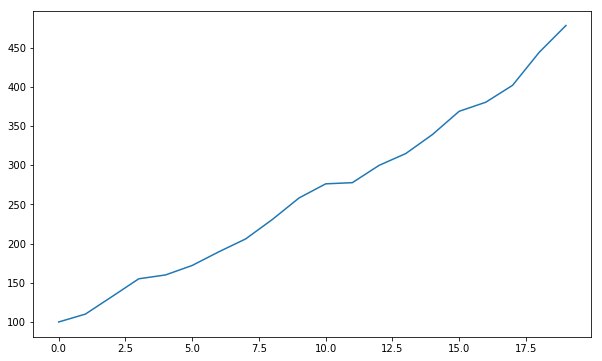

In [168]:
h = None
wt = 100
ww = []
for i in range(i0+1, iT+1, 12):
    t = rx.index[i]
    t_prev = rx.index[i-1]
    pt = bonds.loc[t,:].values
    p_prev = bonds.loc[t_prev,:].values
    p_settle = np.array([100]+list(bonds.loc[t,:].values[:-1]))
    p_open = bonds.loc[t,:].values
    wt = h.dot(p_settle) if h is not None else 100
    h = wt/(5*p_open)
    ww.append(wt)
fig,ax = plt.subplots(1,1,figsize=(10,6))
plt.plot(ww)

### 2-(e)-ii

In [166]:
h = None
wt = 100
ww2 = []
fama_bliss = LinearRegression(fit_intercept=True)
for i in range(i0, iT+1, 12):
    t = rx.index[i]
    t_prev = rx.index[i-1]
    if h is not None:        
        pt = bonds.loc[t,:].values
        p_prev = bonds.loc[t_prev,:].values
        p_settle = np.array([100]+list(bonds.loc[t,:].values[:-1]))
        wt = h.dot(p_settle) if h is not None else 100
        ww2.append(wt)
    else: ww2.append(100)
    p_open = bonds.loc[t,:].values
        
    rx_preds = np.zeros(4)   
    # fb
    h = np.ones(5)/5
    for k in [2,3,4,5]:
        X = (f.loc[:t_prev,k] - y.loc[:t_prev,1]).values
        Xt = (f.loc[t,k] - y.loc[t,1])
        yy = rx.loc[:t_prev,k]
        rxt = rx.loc[t,k]
        fama_bliss.fit(X.reshape(len(X),1), yy)
        rx_preds[k-2] = fama_bliss.predict(Xt)[0]
    rx_pred_bar = rx_preds.mean()
    h[1:] = 0.2+5*rx_pred_bar
    h[0] = 1-h[1:].sum()
    h *= wt/p_open

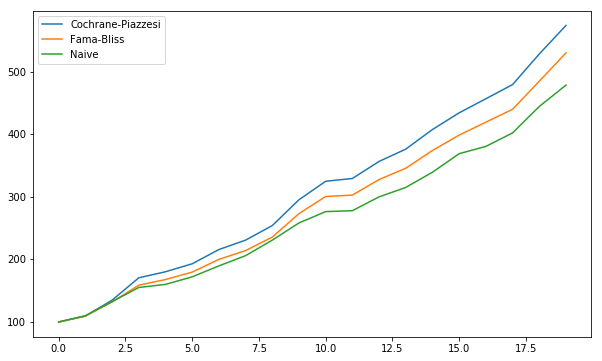

In [169]:
h = None
wt = 100
ww3 = []
fama_bliss = LinearRegression(fit_intercept=True)
for i in range(i0, iT+1, 12):
    t = rx.index[i]
    t_prev = rx.index[i-1]
    
    if h is not None:
        pt = bonds.loc[t,:].values
        p_prev = bonds.loc[t_prev,:].values
        p_prev = bonds.loc[t_prev,:].values
        p_settle = np.array([100]+list(bonds.loc[t,:].values[:-1]))
        wt = h.dot(p_settle) if h is not None else 100
        ww3.append(wt)
    else: ww3.append(100)
    p_open = bonds.loc[t,:].values
        
    rx_preds = np.zeros(4)   
    # cp
    h = np.ones(5)/5

    rx_bar = rx.loc[:t_prev,[2,3,4,5]].mean(axis=1).values
    ff = sm.add_constant(f.loc[:t_prev,:].values)
    ft = np.array([1]+list(f.loc[t,:].values))
    res = sm.OLS(rx_bar, ff).fit()
    gamma = res.params.reshape(6,1)
    reps = []
    for k in [2,3,4,5]:
        X = ff.dot(gamma)
        yy = rx.loc[:t_prev,k]
        Xt = ft.dot(gamma)
        rxt = rx.loc[t,k]
        cochrane_piazzesi.fit(X, yy)
        rx_preds[k-2] = cochrane_piazzesi.predict(Xt.reshape(1,-1))[0]
        
    rx_pred_bar = rx_preds.mean()
    h[1:] = 0.2+5*rx_pred_bar
    h[0] = 1-h[1:].sum()
    h *= wt/p_open
    
fig,ax = plt.subplots(1,1,figsize=(10,6))
plt.plot(ww3, label='Cochrane-Piazzesi')
plt.plot(ww2, label='Fama-Bliss')
plt.plot(ww, label='Naive')
_ = plt.legend()

# Problem 3

## 3-(a)

In [132]:
crc = pd.read_excel('CurrencyReturns.xlsx')

In [136]:
mean = crc.iloc[:,1:].mean(axis=0)*12
vol = crc.iloc[:,1:].std(axis=0)*np.sqrt(12)
sharpe = mean/vol
tab = pd.concat([mean, vol, sharpe], axis=1)
tab.columns = ['mean', 'vol', 'sharpe']
tab

,mean,vol,sharpe
Portfolio1,-0.017920,0.078471,-0.228364
Portfolio2,-0.004030,0.071234,-0.056572
Portfolio3,0.012769,0.073995,0.172562
Portfolio4,0.029169,0.077439,0.376666
Portfolio5,0.036307,0.085203,0.426118
Portfolio6,0.058526,0.097547,0.599975


**Patterns**:

- As forward discount gets larger, the corresponding portfolio gets higher excess return, higher volatility, and higher sharpe ratio.

## 3-(b)

In [138]:
longshorts = crc.iloc[:,2:].subtract(crc.iloc[:,1], 0)
mean = longshorts.mean(axis=0)*12
vol = longshorts.std(axis=0)*np.sqrt(12)
sharpe = mean/vol
tab = pd.concat([mean, vol, sharpe], axis=1)
tab.columns = ['mean', 'vol', 'sharpe']
tab

,mean,vol,sharpe
Portfolio2,0.013890,0.052521,0.264464
Portfolio3,0.030689,0.051792,0.592530
Portfolio4,0.047088,0.061044,0.771384
Portfolio5,0.054227,0.064693,0.838216
Portfolio6,0.076445,0.087918,0.869505


- These statistics have lower excess return and volatility than the stock market.
- Over the past 10 years, the SPY has roughly 0.96 sharpe ratio (source: Yahoo finance). So the currency portfolios have lower sharpe than stock market.

## 3-(c)

In [24]:
RX = crc.iloc[:,1:].mean(axis=1)
HML = crc.Portfolio6 - crc.Portfolio1
XX = sm.add_constant(np.array([RX.values, HML.values]).T)
reps = []
params = []
for k in range(6):
    yy = crc.iloc[:,k+1]
    res = sm.OLS(yy, XX).fit()
    reps.append(report_less(res))
    params.append(res.params)
tab = pd.concat(reps)
tab.index = pd.MultiIndex.from_product(
    [[1,2,3,4,5,6],['est','t-stat','p<0.05','Adj R^2']])
tab

const        x1         x2
1 est      -0.00065   1.02973   -0.38958
  t-stat   -1.80710  58.07180  -27.93299
  p<0.05                  (*)        (*)
  Adj R^2             0.90906           
2 est      -0.00098   0.91203   -0.12682
  t-stat   -1.88383  35.67524   -6.30687
  p<0.05                  (*)        (*)
  Adj R^2             0.77063           
3 est       0.00036   0.95486   -0.12811
  t-stat    0.67771  36.92556   -6.29883
  p<0.05                  (*)        (*)
  Adj R^2             0.78251           
4 est       0.00086   0.98559    0.00041
  t-stat    1.52026  35.68832    0.01868
  p<0.05                  (*)           
  Adj R^2             0.77351           
5 est       0.00108   1.08806    0.03369
  t-stat    1.79403  37.01308    1.45726
  p<0.05                  (*)           
  Adj R^2             0.78801           
6 est      -0.00065   1.02973    0.61042
  t-stat   -1.80710  58.07180   43.76653
  p<0.05                  (*)        (*)
  Adj R^2             0.94115

**Comments**

- (i) The betas for RX factor is roughly 1.0 for all of the 6 portfolios. This implies that RX factor serves as a "benchmark" in the same way as the market return in equity factor model. The results suggests that the 6 portfolios all have about unit exposure to benchmark.
- (ii) The beta for HML increases from portfolio 1 to portfolio 2. This suggests that the role of HML factor can be understood as "unit deviation from the benchmark", where the benchmark is the RX factor. So the average return of portfolios $k$ can be explained as:
$$
\text{Avg. return of portfolio k} = \text{Avg. return of "benchmark"} + \beta_{HML}^{(k)} \times \text{"Deviation from benchmark"}
$$
- (iii) The estimated intercepts has close-to-zero absolute value, and are not statistically significant. So we can say that the two factors did a good job in explaining portfolio returns.